<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [7]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline


### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-02-28 13:48:56--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-02-28 13:48:56 (303 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [15]:
df.shape

(346, 10)

### Convert to date time object 

In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [ ]:
df['loan_status'].value_counts(normalize=True)

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [ ]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: | 

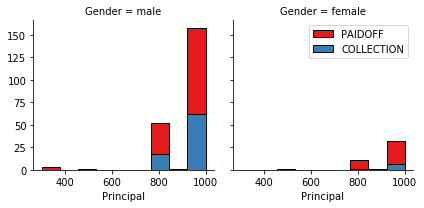

In [8]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1",col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

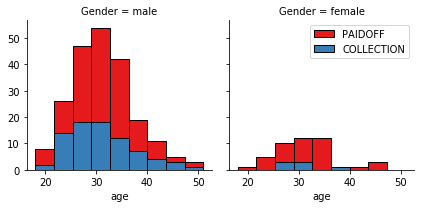

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

6    166
0     87
5     31
2     31
1     20
4      8
3      3
Name: dayofweek, dtype: int64


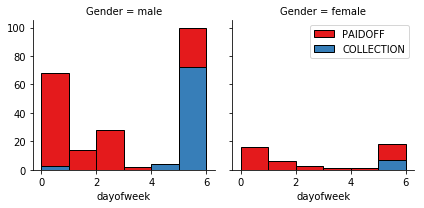

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
print(df['dayofweek'].value_counts())
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 7)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#df['Gender'] = df['Gender'].astype(int)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts()

education             loan_status
Bechalor              PAIDOFF         33
                      COLLECTION      11
High School or Below  PAIDOFF        112
                      COLLECTION      39
Master or Above       COLLECTION       1
                      PAIDOFF          1
college               PAIDOFF        114
                      COLLECTION      35
Name: loan_status, dtype: int64

#### Feature befor One Hot Encoding

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend','education']]
#Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
#Feature.drop(['Master or Above'], axis = 1,inplace=True)

#df1 = pd.get_dummies(df,columns=['education'])

# Label Encoder - Convert categorical variable into indicator variables
#I use it to avoid creating more features as the dataset is not big
le_educ = preprocessing.LabelEncoder()
le_educ.fit(['Bechalor','High School or Below','Master or Above','college'])
Feature['education'] = le_educ.transform(Feature['education'])
Feature.head()


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Principal,terms,age,Gender,weekend,education
0,1000,30,45,0,0,1
1,1000,30,33,1,0,0
2,1000,15,27,0,0,3
3,1000,30,28,1,1,3
4,1000,30,29,0,1,3


### Feature selection

Lets defind feature sets, X:

In [19]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,education
0,1000,30,45,0,0,1
1,1000,30,33,1,0,0
2,1000,15,27,0,0,3
3,1000,30,28,1,1,3
4,1000,30,29,0,1,3


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
print(X[0:5])

[[ 0.51578458  0.92071769  2.33152555 -0.42056004 -1.20577805 -0.64691859]
 [ 0.51578458  0.92071769  0.34170148  2.37778177 -1.20577805 -1.5212695 ]
 [ 0.51578458 -0.95911111 -0.65321055 -0.42056004 -1.20577805  1.10178323]
 [ 0.51578458  0.92071769 -0.48739188  2.37778177  0.82934003  1.10178323]
 [ 0.51578458  0.92071769 -0.3215732  -0.42056004  0.82934003  1.10178323]]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [21]:
# ============= Split the data into training and testing sets =============
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(\
    X, y, test_size = 0.25, random_state = 3)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (259, 6)
Training Labels Shape: (259,)
Testing Features Shape: (87, 6)
Testing Labels Shape: (87,)


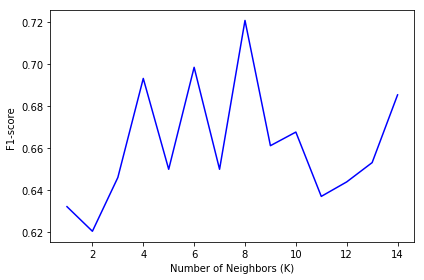

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#------- Calculate the accuracy of KNN for different neighbors ---------
neigh = 15
f1score = np.zeros((neigh-1))

for n in range(1,neigh):
    #Train Model and Predict  
    KNeigh = KNeighborsClassifier(n_neighbors = n).fit(train_features, train_labels)
    predictions_test=KNeigh.predict(test_features)
    f1score[n-1] = metrics.f1_score(test_labels, predictions_test, average='weighted')

#Plot F1 score for each neighbor
plt.plot(range(1,neigh),f1score,'b')
plt.ylabel('F1-score ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [23]:
# Initialize the model - withe the neighbor that generates the best results
KNeigh = KNeighborsClassifier(n_neighbors = 8)
#Fit/train the learner to the training data
KNeigh = KNeigh.fit(train_features, train_labels)
predictions_train_knn = KNeigh.predict(train_features)
predictions_test_knn = KNeigh.predict(test_features)

# ========= Accuracy evaluation =========
print("Train set Accuracy: %.6f " %metrics.accuracy_score(train_labels, predictions_train_knn))
print("Train set F1 score: %.6f \n" %metrics.f1_score(train_labels, predictions_train_knn, average='weighted'))

accuracy = metrics.accuracy_score(test_labels, predictions_test_knn)
print("Test set Accuracy: %.6f" %accuracy)
f1 =  metrics.f1_score(test_labels, predictions_test_knn, average='weighted')
print("Test set F1 score: %.6f" %f1)
recall = metrics.recall_score(test_labels, predictions_test_knn, average='weighted')
print("Test set Recall score: %.6f" %recall )
precision = metrics.precision_score(test_labels, predictions_test_knn, average='weighted')
print("Test set Precision score: %.6f" %precision )
jaccard = metrics.jaccard_similarity_score(test_labels, predictions_test_knn)
print("Test set Jaccard_similarity score: %.6f \n" %jaccard )
print(metrics.classification_report(test_labels, predictions_test_knn))
print(metrics.confusion_matrix(test_labels, predictions_test_knn))

Train set Accuracy: 0.833977 
Train set F1 score: 0.828302 

Test set Accuracy: 0.712644
Test set F1 score: 0.720889
Test set Recall score: 0.712644
Test set Precision score: 0.733691
Test set Jaccard_similarity score: 0.712644 

              precision    recall  f1-score   support

  COLLECTION       0.46      0.57      0.51        23
     PAIDOFF       0.83      0.77      0.80        64

   micro avg       0.71      0.71      0.71        87
   macro avg       0.65      0.67      0.65        87
weighted avg       0.73      0.71      0.72        87

[[13 10]
 [15 49]]


# Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

#Fit/train the learner to the training data
model_tree = DecisionTreeClassifier(criterion="entropy").fit(train_features, train_labels)
predictions_train_tree = model_tree.predict(train_features)
predictions_test_tree = model_tree.predict(test_features)

# ========= Accuracy evaluation =========
print("Train set Accuracy: %.6f " %metrics.accuracy_score(train_labels, predictions_train_tree))
print("Train set F1 score: %.6f \n" %metrics.f1_score(train_labels, predictions_train_tree, average='weighted'))

accuracy = metrics.accuracy_score(test_labels, predictions_test_tree)
print("Test set Accuracy: %.6f" %accuracy)
f1 =  metrics.f1_score(test_labels, predictions_test_tree, average='weighted')
print("Test set F1 score: %.6f" %f1)
recall = metrics.recall_score(test_labels, predictions_test_tree, average='weighted')
print("Test set Recall score: %.6f" %recall )
precision = metrics.precision_score(test_labels, predictions_test_tree, average='weighted')
print("Test set Precision score: %.6f" %precision )
jaccard = metrics.jaccard_similarity_score(test_labels, predictions_test_tree)
print("Test set Jaccard_similarity score: %.6f \n" %jaccard )
print(metrics.classification_report(test_labels, predictions_test_tree))
print(metrics.confusion_matrix(test_labels, predictions_test_tree))

Train set Accuracy: 0.926641 
Train set F1 score: 0.927567 

Test set Accuracy: 0.620690
Test set F1 score: 0.627749
Test set Recall score: 0.620690
Test set Precision score: 0.636083
Test set Jaccard_similarity score: 0.620690 

              precision    recall  f1-score   support

  COLLECTION       0.31      0.35      0.33        23
     PAIDOFF       0.75      0.72      0.74        64

   micro avg       0.62      0.62      0.62        87
   macro avg       0.53      0.53      0.53        87
weighted avg       0.64      0.62      0.63        87

[[ 8 15]
 [18 46]]


# Support Vector Machine

In [26]:
from sklearn import svm
#Fit/train the learner to the training data
model_svc = svm.SVC(kernel='linear', class_weight='balanced').fit(train_features, train_labels)
predictions_train_svc = model_svc.predict(train_features)
predictions_test_svc = model_svc.predict(test_features)
model_svc

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [27]:
# ========= Accuracy evaluation =========
print("Train set Accuracy: %.6f " %metrics.accuracy_score(train_labels, predictions_train_svc))
print("Train set F1 score: %.6f \n" %metrics.f1_score(train_labels, predictions_train_svc, average='weighted'))

accuracy = metrics.accuracy_score(test_labels, predictions_test_svc)
print("Test set Accuracy: %.6f" %accuracy)
f1 =  metrics.f1_score(test_labels, predictions_test_svc, average='weighted')
print("Test set F1 score: %.6f" %f1)
recall = metrics.recall_score(test_labels, predictions_test_svc, average='weighted')
print("Test set Recall score: %.6f" %recall )
precision = metrics.precision_score(test_labels, predictions_test_svc, average='weighted')
print("Test set Precision score: %.6f" %precision )
jaccard = metrics.jaccard_similarity_score(test_labels, predictions_test_svc)
print("Test set Jaccard_similarity score: %.6f \n" %jaccard )
print(metrics.classification_report(test_labels, predictions_test_svc))
print(metrics.confusion_matrix(test_labels, predictions_test_svc))

Train set Accuracy: 0.648649 
Train set F1 score: 0.670293 

Test set Accuracy: 0.609195
Test set F1 score: 0.624226
Test set Recall score: 0.609195
Test set Precision score: 0.818391
Test set Jaccard_similarity score: 0.609195 

              precision    recall  f1-score   support

  COLLECTION       0.40      0.96      0.56        23
     PAIDOFF       0.97      0.48      0.65        64

   micro avg       0.61      0.61      0.61        87
   macro avg       0.68      0.72      0.60        87
weighted avg       0.82      0.61      0.62        87

[[22  1]
 [33 31]]


# Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

model_LR = LogisticRegression(C=0.01, solver='liblinear').fit(train_features, train_labels)
predictions_train_LR = model_LR.predict(train_features)
predictions_test_LR = model_LR.predict(test_features)
model_LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [29]:
predictions_test_LR_prob = model_LR.predict_proba(test_features)
#print(predictions_test_LR_prob) #probabilities of dataset in the binary labels
logloss = metrics.log_loss(test_labels, predictions_test_LR_prob)
print("LogLoss: : %.2f" %logloss)


LogLoss: : 0.57


In [30]:
# ========= Accuracy evaluation =========
print("Train set Accuracy: %.6f " %metrics.accuracy_score(train_labels, predictions_train_LR))
print("Train set F1 score: %.6f \n" %metrics.f1_score(train_labels, predictions_train_LR, average='weighted'))

accuracy = metrics.accuracy_score(test_labels, predictions_test_LR)
print("Test set Accuracy: %.6f" %accuracy)
f1 =  metrics.f1_score(test_labels, predictions_test_LR, average='weighted')
print("Test set F1 score: %.6f" %f1)
recall = metrics.recall_score(test_labels, predictions_test_LR, average='weighted')
print("Test set Recall score: %.6f" %recall )
precision = metrics.precision_score(test_labels, predictions_test_LR, average='weighted')
print("Test set Precision score: %.6f" %precision )
jaccard = metrics.jaccard_similarity_score(test_labels, predictions_test_LR)
print("Test set Jaccard_similarity score: %.6f \n" %jaccard )
print(metrics.classification_report(test_labels, predictions_test_LR))
print(metrics.confusion_matrix(test_labels, predictions_test_LR))


Train set Accuracy: 0.741313 
Train set F1 score: 0.657032 

Test set Accuracy: 0.735632
Test set F1 score: 0.659699
Test set Recall score: 0.735632
Test set Precision score: 0.681692
Test set Jaccard_similarity score: 0.735632 

              precision    recall  f1-score   support

  COLLECTION       0.50      0.09      0.15        23
     PAIDOFF       0.75      0.97      0.84        64

   micro avg       0.74      0.74      0.74        87
   macro avg       0.62      0.53      0.50        87
weighted avg       0.68      0.74      0.66        87

[[ 2 21]
 [ 2 62]]


# Model Evaluation using Test set¶


In [31]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-02-28 13:51:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-02-28 13:51:00 (313 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [32]:
test_df = pd.read_csv('loan_test.csv')

# -------- Convert to date time object --------
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

# evaulate weekend field
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# Convert Gender into[0, 1]
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# Label Encoder - Convert categorical variable into indicator variables
test_feature = test_df[['Principal','terms','age','Gender','weekend','education']]
le_educ = preprocessing.LabelEncoder()
le_educ.fit(['Bechalor','High School or Below','Master or Above','college'])
test_feature['education'] = le_educ.transform(test_feature['education'])
print(test_feature.head())

# Normalize the whole train dataset
test_X = preprocessing.StandardScaler().fit(test_feature).transform(test_feature)

#Label data
test_y = test_df['loan_status'].values

#Save the results of the different models
classifiers_results = pd.DataFrame(columns=['Jaccard', 'F1-score', 'Recall','Precision', 'LogLoss'], index=['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'])


   Principal  terms  age  Gender  weekend  education
0       1000     30   50       1        0          0
1        300      7   35       0        1          2
2       1000     30   43       1        1          1
3       1000     30   26       0        1          3
4        800     15   29       0        1          0


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:22: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


In [33]:
# -------- Evaluation of KNN --------
predictions_test_knn = KNeigh.predict(test_X)

accuracy = metrics.accuracy_score(test_y, predictions_test_knn)
print("Test set Accuracy: %.6f" %accuracy)
f1 =  metrics.f1_score(test_y, predictions_test_knn, average='weighted')
print("Test set F1 score: %.6f" %f1)
recall = metrics.recall_score(test_y, predictions_test_knn, average='weighted')
print("Test set Recall score: %.6f" %recall )
precision = metrics.precision_score(test_y, predictions_test_knn, average='weighted')
print("Test set Precision score: %.6f" %precision )
jaccard = metrics.jaccard_similarity_score(test_y, predictions_test_knn)
print("Test set Jaccard_similarity score: %.6f \n" %jaccard )

# Save the evaluation metrics of the predictor
classifiers_results.loc['KNN'] = [jaccard, f1, recall,precision, '-' ]

Test set Accuracy: 0.666667
Test set F1 score: 0.666667
Test set Recall score: 0.666667
Test set Precision score: 0.666667
Test set Jaccard_similarity score: 0.666667 



In [34]:
# -------- Evaluation of Decision Tree --------

predictions_test_tree = model_tree.predict(test_X)

accuracy = metrics.accuracy_score(test_y, predictions_test_tree)
print("Test set Accuracy: %.6f" %accuracy)
f1 =  metrics.f1_score(test_y, predictions_test_tree, average='weighted')
print("Test set F1 score: %.6f" %f1)
recall = metrics.recall_score(test_y, predictions_test_tree, average='weighted')
print("Test set Recall score: %.6f" %recall )
precision = metrics.precision_score(test_y, predictions_test_tree, average='weighted')
print("Test set Precision score: %.6f" %precision )
jaccard = metrics.jaccard_similarity_score(test_y, predictions_test_tree)
print("Test set Jaccard_similarity score: %.6f \n" %jaccard )

# Save the evaluation metrics of the predictor
classifiers_results.loc['Decision Tree'] = [jaccard, f1, recall,precision, '-' ]

Test set Accuracy: 0.722222
Test set F1 score: 0.710576
Test set Recall score: 0.722222
Test set Precision score: 0.703547
Test set Jaccard_similarity score: 0.722222 



In [35]:
# -------- Evaluation of SVC --------
predictions_test_svc = model_svc.predict(test_X)

accuracy = metrics.accuracy_score(test_y, predictions_test_svc)
print("Test set Accuracy: %.6f" %accuracy)
f1 =  metrics.f1_score(test_y, predictions_test_svc, average='weighted')
print("Test set F1 score: %.6f" %f1)
recall = metrics.recall_score(test_y, predictions_test_svc, average='weighted')
print("Test set Recall score: %.6f" %recall )
precision = metrics.precision_score(test_y, predictions_test_svc, average='weighted')
print("Test set Precision score: %.6f" %precision )
jaccard = metrics.jaccard_similarity_score(test_y, predictions_test_svc)
print("Test set Jaccard_similarity score: %.6f \n" %jaccard )

# Save the evaluation metrics of the predictor
classifiers_results.loc['SVM'] = [jaccard, f1, recall,precision, '-' ]

Test set Accuracy: 0.592593
Test set F1 score: 0.609568
Test set Recall score: 0.592593
Test set Precision score: 0.802832
Test set Jaccard_similarity score: 0.592593 



In [36]:
# -------- Evaluation of Logistic Regression --------
predictions_test_LR = model_LR.predict(test_X)

predictions_test_LR_prob = model_LR.predict_proba(test_X)
#print(predictions_test_LR_prob) #probabilities of dataset in the binary labels
logloss = metrics.log_loss(test_y, predictions_test_LR_prob)
print("LogLoss: : %.2f" %logloss)

accuracy = metrics.accuracy_score(test_y, predictions_test_LR)
print("Test set Accuracy: %.6f" %accuracy)
f1 =  metrics.f1_score(test_y, predictions_test_LR, average='weighted')
print("Test set F1 score: %.6f" %f1)
recall = metrics.recall_score(test_y, predictions_test_LR, average='weighted')
print("Test set Recall score: %.6f" %recall )
precision = metrics.precision_score(test_y, predictions_test_LR, average='weighted')
print("Test set Precision score: %.6f" %precision )
jaccard = metrics.jaccard_similarity_score(test_y, predictions_test_LR)
print("Test set Jaccard_similarity score: %.6f \n" %jaccard )

# Save the evaluation metrics of the predictor
classifiers_results.loc['LogisticRegression'] = [jaccard, f1, recall,precision, logloss ]

LogLoss: : 0.57
Test set Accuracy: 0.759259
Test set F1 score: 0.671764
Test set Recall score: 0.759259
Test set Precision score: 0.818309
Test set Jaccard_similarity score: 0.759259 



# Report - Model Evaluation using Test set

In [37]:
#Report - different evaluation metrics:
classifiers_results

,Jaccard,F1-score,Recall,Precision,LogLoss
KNN,0.666667,0.666667,0.666667,0.666667,-
Decision Tree,0.722222,0.710576,0.722222,0.703547,-
SVM,0.592593,0.609568,0.592593,0.802832,-
LogisticRegression,0.759259,0.671764,0.759259,0.818309,0.573159
